In [1]:
import tensorflow as tf
import numpy as np
import timeit
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
from scipy.interpolate import griddata
from scipy import stats

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
class Sampler:
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y

class Black_Scholes:

    tf.compat.v1.disable_eager_execution()

    def __init__(self, layers, operator, ic, bc, res, r, sigma, delta, model, stiff_ratio):

        self.operator = operator
        self.ic = ic
        self.bc = bc
        self.res = res

        self.model = model
        self.stiff_ratio = stiff_ratio

        # Constant
        self.sigma = tf.constant(sigma, dtype=tf.float32)
        self.r = tf.constant(r, dtype = tf.float32)
        self.delta = tf.constant(delta, dtype = tf.float32)

        # Decay rate = 0.9
        self.rate = 0.9
        self.adaptive_constant_ic_val = np.array(1.0) # konstanta ic
        self.adaptive_constant_bc_val = np.array(1.0) # konstanta bc

        # Initial weight + bias
        self.layers = layers
        self.weight, self.bias = self.initialize_NN(layers)

        if model in ['M3', 'M4']:
            self.encoder_weight_1 = self.xavier_init([2, layers[1]])
            self.encoder_bias_1 = self.xavier_init([1,layers[1]])

            self.encoder_weight_2 = self.xavier_init([2, layers[1]])
            self.encoder_bias_2 = self.xavier_init([1, layers[1]])

        self.sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(log_device_placement = True))

        # Define Placeholders and Computational Graph
        self.t_v_tf = tf.compat.v1.placeholder(tf.float32, shape = (None,1))
        self.s_v_tf = tf.compat.v1.placeholder(tf.float32, shape = (None,1))

        self.t_ic_tf = tf.compat.v1.placeholder(tf.float32, shape = (None,1))
        self.s_ic_tf = tf.compat.v1.placeholder(tf.float32, shape = (None,1))
        self.v_ic_tf = tf.compat.v1.placeholder(tf.float32, shape = (None,1))

        self.t_bc1_tf = tf.compat.v1.placeholder(tf.float32, shape = (None,1))
        self.s_bc1_tf = tf.compat.v1.placeholder(tf.float32, shape = (None,1))
        self.v_bc1_tf = tf.compat.v1.placeholder(tf.float32, shape = (None,1))

        self.t_r_tf = tf.compat.v1.placeholder(tf.float32, shape = (None,1))
        self.s_r_tf = tf.compat.v1.placeholder(tf.float32, shape = (None,1))
        self.res_tf = tf.compat.v1.placeholder(tf.float32, shape = (None,1))

        self.adaptive_constant_ic_tf = tf.compat.v1.placeholder(tf.float32, shape=self.adaptive_constant_ic_val.shape)
        self.adaptive_constant_bc_tf = tf.compat.v1.placeholder(tf.float32, shape=self.adaptive_constant_bc_val.shape)

        # Evaluate Predictions
        self.v_ic_pred = self.net_u(self.t_ic_tf, self.s_ic_tf)
        self.v_bc1_pred = self.net_u(self.t_bc1_tf, self.s_bc1_tf)

        self.v_pred = self.net_u(self.t_v_tf, self.s_v_tf)
        self.res_pred = self.net_r(self.t_r_tf, self.s_r_tf)

        # Initial and Boundary Loss
        self.loss_ic = tf.reduce_mean(tf.square(self.v_ic_tf - self.v_ic_pred))
        self.loss_bc1 = tf.reduce_mean(tf.square(self.v_bc1_pred - self.v_bc1_tf))

        self.loss_bcs = self.adaptive_constant_bc_tf * (self.loss_bc1)
        self.loss_ics = self.adaptive_constant_ic_tf * (self.loss_ic)
        self.loss_v = self.loss_ics + self.loss_bcs

        self.loss_res = tf.reduce_mean(tf.square(self.res_pred))
        # - self.res_tf
        # Total Loss
        self.loss = self.loss_res + self.loss_v

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        initial_learning_rate = 1e-3
        self.learning_rate = tf.compat.v1.train.exponential_decay(initial_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)

        # Passing global_step to minimize() will increment it at each step
        self.train_op = tf.compat.v1.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step = self.global_step)

        # Logger
        self.loss_ic_log = []
        self.loss_bc_log = []
        self.loss_r_log = []
        self.saver = tf.compat.v1.train.Saver()

        # Generate dictionary for gradients storage
        self.dict_gradients_res_layers = self.generate_grad_dict(self.layers)
        self.dict_gradients_ic_layers = self.generate_grad_dict(self.layers)
        self.dict_gradients_bc_layers = self.generate_grad_dict(self.layers)

        # Gradients Storage
        self.grad_res = []
        self.grad_ic = []
        self.grad_bc = []

        for i in range(len(self.layers) - 1):
            self.grad_res.append(tf.gradients(self.loss_res, self.weight[i])[0])
            self.grad_bc.append(tf.gradients(self.loss_bcs, self.weight[i])[0])
            self.grad_ic.append(tf.gradients(self.loss_ics, self.weight[i])[0])

        # Store Adaptive Constant
        self.adaptive_constant_ic_log = []
        self.adaptive_constant_bc_log = []

        # Compute the adaptive constant
        self.adaptive_constant_ic_list = []
        self.adaptive_constant_bc_list = []

        self.max_grad_res_list = []
        self.mean_grad_bc_list = []
        self.mean_grad_ic_list = []

        for i in range(len(self.layers) - 1):
            self.max_grad_res_list.append(tf.reduce_max(tf.abs(self.grad_res[i])))
            self.mean_grad_bc_list.append(tf.reduce_mean(tf.abs(self.grad_bc[i])))
            self.mean_grad_ic_list.append(tf.reduce_mean(tf.abs(self.grad_ic[i])))

        self.max_grad_res = tf.reduce_max(tf.stack(self.max_grad_res_list))
        self.mean_grad_bc = tf.reduce_mean(tf.stack(self.mean_grad_bc_list))
        self.mean_grad_ic = tf.reduce_mean(tf.stack(self.mean_grad_ic_list))

        self.adaptive_constant_bc = self.max_grad_res / self.mean_grad_bc
        self.adaptive_constant_ic = self.max_grad_res / self.mean_grad_ic

        # Stiff Ratio
        if self.stiff_ratio:
            self.Hessian, self.Hessian_ic, self.Hessian_bc, self.Hessian_res = self.get_H_op()
            self.eigenvalue, _ = tf.linalg.eigh(self.Hessian)
            self.eigenvalue_ic, _ = tf.linalg.eigh(self.Hessian_ic)
            self.eigenvalue_bc, _ = tf.linalg.eigh(self.Hessian_bc)
            self.eigenvalue_res, _ = tf.linalg.eigh(self.Hessian_res)

            self.eigenvalue_log = []
            self.eigenvalue_ic_log = []
            self.eigenvalue_bc_log = []
            self.eigenvalue_res_log = []

        # Initialize tensorflow variables
        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)

    # Create dictionary to store gradients
    def generate_grad_dict(self, layers):
        num = len(layers) - 1
        grad_dict = {}
        for i in range(num):
            grad_dict['layer_{}'.format(i + 1)] = []
        return grad_dict

    # Save gradients
    def save_gradients(self, tf_dict):
        num_layers = len(self.layers)
        for i in range(num_layers - 1):
            grad_ic_value, grad_bc_value, grad_res_value = self.sess.run([self.grad_ic[i], self.grad_bc[i], self.grad_res[i]], feed_dict = tf_dict)

            self.dict_gradients_ic_layers['layer_' + str(i + 1)].append(grad_ic_value.flatten())
            self.dict_gradients_bc_layers['layer_' + str(i + 1)].append(grad_bc_value.flatten())
            self.dict_gradients_res_layers['layer_' + str(i + 1)].append(grad_res_value.flatten())
        return None

    def flatten(self, vectors):
        return tf.concat([tf.reshape(v, [-1]) for v in vectors], axis = 0)

    def get_Hv(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss, self.weight))
        vprod = tf.math.multiply(loss_gradients, tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weight))
        return Hv_op

    def get_Hv_ic(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_ics, self.weight))
        vprod = tf.math.multiply(loss_gradients, tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weight))
        return Hv_op

    def get_Hv_bc(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_bcs, self.weight))
        vprod = tf.math.multiply(loss_gradients, tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weight))
        return Hv_op

    def get_Hv_res(self, v):
        loss_gradients = self.flatten(tf.gradients(self.loss_res, self.weight))
        vprod = tf.math.multiply(loss_gradients, tf.stop_gradient(v))
        Hv_op = self.flatten(tf.gradients(vprod, self.weight))
        return Hv_op

    def get_H_op(self):
        self.P = self.flatten(self.weight).get_shape().as_list()[0]
        H = tf.map_fn(self.get_Hv, tf.eye(self.P, self.P), dtype = 'float32')
        H_ic = tf.map_fn(self.get_Hv_ic, tf.eye(self.P, self.P), dtype = 'float32')
        H_bc = tf.map_fn(self.get_Hv_bc, tf.eye(self.P, self.P), dtype = 'float32')
        H_res = tf.map_fn(self.get_Hv_res, tf.eye(self.P, self.P), dtype = 'float32')
        return H, H_ic, H_bc, H_res

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.compat.v1.random_normal([in_dim, out_dim], dtype = tf.float32) * xavier_stddev, dtype=tf.float32)

    def initialize_NN(self, layers):
        weight = []
        bias = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size = [layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1, layers[l+1]], dtype = tf.float32), dtype = tf.float32)
            weight.append(W)
            bias.append(b)
        return weight, bias

    # Evaluate the forward pass
    def forward_pass(self, H):
        if self.model in ['M1', 'M2']:
            num_layers = len(self.layers)
            for l in range(0, num_layers - 2):
                W = self.weight[l]
                b = self.bias[l]
                H = tf.tanh(tf.add(tf.matmul(H, W), b))
            W = self.weight[-1]
            b = self.bias[-1]
            H = tf.add(tf.matmul(H, W), b)
            return H

        if self.model in ['M3', 'M4']:
            num_layers = len(self.layers)
            encoder_1 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weight_1), self.encoder_bias_1))
            encoder_2 = tf.tanh(tf.add(tf.matmul(H, self.encoder_weight_2), self.encoder_bias_2))

            for l in range(0, num_layers - 2):
                W = self.weight[l]
                b = self.bias[l]
                H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_1) + \
                    tf.math.multiply(1 - tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_2)

            W = self.weight[-1]
            b = self.bias[-1]
            H = tf.add(tf.matmul(H, W), b)
            return H

    # Forward pass for u
    # This code is for initial and boundary condition
    def net_u(self, t, s):
        v = self.forward_pass(tf.concat([t, s], 1))
        return v

    # Forward pass for residual
    def net_r(self, t, s):
        v = self.net_u(t, s)
        residual = self.operator(v, t, s, self.r, self.sigma, self.delta)
        return residual

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        return X, Y

    # Trains the model by minimizing the MSE loss
    def train(self, nIter = 10000):
        start_time = timeit.default_timer()

        # Fetch boundary mini-batches
        s_ic_batch, v_ic_batch = self.fetch_minibatch(self.ic, 250)
        s_bc1_batch, v_bc1_batch = self.fetch_minibatch(self.bc, 250)

        # Fetch residual mini-batch
        s_res_batch, f_res_batch = self.fetch_minibatch(self.res, 62500)

        # Define a dictionary for associating placeholder with data
        tf_dict = {self.t_ic_tf: s_ic_batch[:, 0:1], self.s_ic_tf: s_ic_batch[:, 1:2],
                    self.v_ic_tf: v_ic_batch,
                    self.t_bc1_tf: s_bc1_batch[:, 0:1], self.s_bc1_tf: s_bc1_batch[:, 1:2],
                    self.v_bc1_tf: v_bc1_batch,
                    self.t_r_tf: s_res_batch[:, 0:1], self.s_r_tf: s_res_batch[:, 1:2],
                    self.res_tf: f_res_batch,
                    self.adaptive_constant_ic_tf: self.adaptive_constant_ic_val,
                    self.adaptive_constant_bc_tf: self.adaptive_constant_ic_val}

        for it in range(nIter):

            # Run the tensorflow session to minimize losss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_ic_value, loss_bc_value, loss_r_value = self.sess.run([self.loss_ics, self.loss_bcs, self.loss_res], tf_dict)

                if self.model in ['M2', 'M4']:
                    # Compute the adaptive constant
                    adaptive_constant_ic_val, adaptive_constant_bc_val = self.sess.run([self.adaptive_constant_ic, self.adaptive_constant_bc], tf_dict)

                    self.adaptive_constant_ic_val = adaptive_constant_ic_val * (1.0 - self.rate) + self.rate * self.adaptive_constant_ic_val
                    self.adaptive_constant_bc_val = adaptive_constant_bc_val * (1.0 - self.rate) + self.rate * self.adaptive_constant_bc_val

                # Store loss and adaptive weights
                self.loss_ic_log.append(loss_ic_value)
                self.loss_bc_log.append(loss_bc_value)
                self.loss_r_log.append(loss_r_value)

                self.adaptive_constant_ic_log.append(self.adaptive_constant_ic_val)
                self.adaptive_constant_bc_log.append(self.adaptive_constant_bc_val)

                print('It: %d, Loss: %.3e, Loss_u0: %.3e, Loss_ub: %.3e, Loss_r: %.3e, Time: %.2f' %
                      (it, loss_value, loss_ic_value, loss_bc_value, loss_r_value, elapsed))
                print("constant_ic_val: {:.3f}, constant_bc_val: {:.3f}".format(
                    self.adaptive_constant_ic_val,
                    self.adaptive_constant_bc_val))
                start_time = timeit.default_timer()

            # Compute the eigenvalues of the Hessian of losses
            if self.stiff_ratio:
                if it % 1000 == 0:
                    print("Eigenvalues information stored...")
                    eigenvalue, eigenvalue_ic, eigenvalue_bc, eigenvalue_res = self.sess.run([self.eigenvalue, self.eigenvalue_ic, self.eigenvalue_bc, self.eigenvalue_res], tf_dict)

                    self.eigenvalue_log.append(eigenvalue)
                    self.eigenvalue_ic_log.append(eigenvalue_ic)
                    self.eigenvalue_bc_log.append(eigenvalue_bc)
                    self.eigenvalue_res_log.append(eigenvalue_res)

            if it % 10000 == 0:
                self.save_gradients(tf_dict)
                print("Gradients information stored...")

    def predict_v(self, s_star):
            tf_dict = {self.t_v_tf: s_star[:, 0:1], self.s_v_tf: s_star[:, 1:2]}
            v_star = self.sess.run(self.v_pred, tf_dict)
            return v_star

    def predict_r(self, s_star):
        tf_dict = {self.t_r_tf: s_star[:, 0:1], self.s_r_tf: s_star[:, 1:2]}
        r_star = self.sess.run(self.res_pred, tf_dict)
        return r_star




In [5]:
K = 10
r = 0.05
sigma = 0.3
delta = 0.03
s_min = 0.0
s_max = 20.0
t_min = 0.0
t_max = 1.0

In [6]:
def initial(v):
  return np.maximum(v[:,1:2]-K,0)

def boundary_1(v):
    return v[:,1:2]*0

In [7]:
def u(v):
    ans = []
    n_d1 = []
    n_d2 = []
    for i in range(len(v[:,0:1])):
        if v[i,0:1] == 1:
            ans = np.append(ans,max(v[i, 1:2] - K, 0))
        elif v[i, 1:2] == 0:
            ans = np.append(ans,0)
        else:
            d1 = (math.log(v[i,1:2]/K) + (r - delta + 0.5 * sigma**2)*(t_max - v[i,0:1]))/(sigma * math.sqrt(t_max - v[i,0:1]))
            d2 = d1 - (sigma * math.sqrt(t_max - v[i,0:1]))
            n_d1 = stats.norm.cdf(d1)
            n_d2 = stats.norm.cdf(d2)
            ans = np.append(ans, v[i,1:2]* np.exp(-1*delta*(t_max-v[i,0:1]))* n_d1 - K* np.exp(-1* r * (t_max - v[i,0:1])) * n_d2)
    return ans

In [8]:
def f(v):
    return v[:,1:2]*0

def operator(v, t, s, r, sigma, delta):
    v_t = tf.gradients(v,t)[0]
    v_s = tf.gradients(v,s)[0]
    v_ss = tf.gradients(v_s,s)[0]
    residual = v_t + 0.5* sigma**2 * s**2 * v_ss + (r - delta)*s*v_s - r*v
    return residual

In [9]:
# Domain Boundaries
ic_coords = np.array([[t_max,s_min],[t_max,s_max]])
bc1_coords = np.array([[t_min,s_min],[t_max, s_min]])
dom_coords = np.array([[t_min,s_min],[t_max,s_max]])

# Create initial conditions random data
ic = Sampler(2, ic_coords, lambda v: initial(v), name = 'Initial Condition')

bc = Sampler(2, bc1_coords, lambda v: boundary_1(v), name = 'Boundary 1 Condition')

# Create residual conditions random data
res = Sampler(2, dom_coords, lambda v: f(v), name = 'Residual')

In [10]:
# Define model
layers = [2,50,50,50,50,1]
model = 'M1'
stiff_ratio = False
model = Black_Scholes(layers, operator, ic, bc, res, r, sigma, delta, model, stiff_ratio)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [11]:
# Train model
model.train(nIter = 40000)

Streaming output truncated to the last 5000 lines.
It: 15010, Loss: 4.516e-04, Loss_u0: 3.237e-04, Loss_ub: 2.578e-07, Loss_r: 1.277e-04, Time: 0.30
constant_ic_val: 1.000, constant_bc_val: 1.000
It: 15020, Loss: 4.511e-04, Loss_u0: 3.233e-04, Loss_ub: 2.577e-07, Loss_r: 1.275e-04, Time: 0.30
constant_ic_val: 1.000, constant_bc_val: 1.000
It: 15030, Loss: 4.507e-04, Loss_u0: 3.230e-04, Loss_ub: 2.576e-07, Loss_r: 1.274e-04, Time: 0.30
constant_ic_val: 1.000, constant_bc_val: 1.000
It: 15040, Loss: 4.502e-04, Loss_u0: 3.226e-04, Loss_ub: 2.576e-07, Loss_r: 1.273e-04, Time: 0.30
constant_ic_val: 1.000, constant_bc_val: 1.000
It: 15050, Loss: 4.497e-04, Loss_u0: 3.222e-04, Loss_ub: 2.585e-07, Loss_r: 1.272e-04, Time: 0.30
constant_ic_val: 1.000, constant_bc_val: 1.000
It: 15060, Loss: 4.493e-04, Loss_u0: 3.219e-04, Loss_ub: 2.927e-07, Loss_r: 1.271e-04, Time: 0.30
constant_ic_val: 1.000, constant_bc_val: 1.000
It: 15070, Loss: 4.518e-04, Loss_u0: 3.221e-04, Loss_ub: 2.703e-06, Loss_r: 1.2

In [12]:
# Test data
nn = 100
t = np.linspace(dom_coords[0,0], dom_coords[1,0], nn)[:, None]
s = np.linspace(dom_coords[0,1], dom_coords[1,1], nn)[:, None]
t, s = np.meshgrid(t, s)
X_star = np.hstack((t.flatten()[:, None], s.flatten()[:, None]))

# Exact Solution
v_star = u(X_star)
f_star = f(X_star)
v_star = v_star.reshape(len(X_star[:,0:1]),1)

# Predictions
v_pred = model.predict_v(X_star)

error_v = np.linalg.norm(v_star - v_pred, 2)
print('Relative L2 error_v: {:.2e}'.format(error_v))

/tmp/ipython-input-7-1605100559.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1 = (math.log(v[i,1:2]/K) + (r - delta + 0.5 * sigma**2)*(t_max - v[i,0:1]))/(sigma * math.sqrt(t_max - v[i,0:1]))
/tmp/ipython-input-7-1605100559.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d2 = d1 - (sigma * math.sqrt(t_max - v[i,0:1]))
/tmp/ipython-input-7-1605100559.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1 = (math.log(v[i,1:2]/K) + (r - delta + 0.5 * si

Relative L2 error_v: 2.00e+01


In [13]:
# Test data initial
nn = 100
t1 = 1
s1 = np.linspace(dom_coords[0,1], dom_coords[1,1], nn)[:, None]
t1, s1 = np.meshgrid(t1, s1)
X1_star = np.hstack((t1.flatten()[:, None], s1.flatten()[:, None]))

# t = 1 , S = bervariasi
# Exact Solution
v1_star = u(X1_star)
f1_star = f(X1_star)
v1_star = v1_star.reshape(len(X1_star[:,0:1]),1)

# Predictions
v1_pred = model.predict_v(X1_star)

error_v = np.linalg.norm(v1_star - v1_pred, 2)
print('Relative L2 error_v: {:.2e}'.format(error_v))

Relative L2 error_v: 8.36e-02


In [14]:
# Test data boundary
nn = 100
t2 = np.linspace(dom_coords[0,0], dom_coords[1,0], nn)[:, None]
s2 = 0
t2, s2 = np.meshgrid(t2, s2)
X2_star = np.hstack((t2.flatten()[:, None], s2.flatten()[:, None]))

# t = bervariasi , S = 0
# Exact Solution
v2_star = u(X2_star)
f2_star = f(X2_star)
v2_star = v2_star.reshape(len(X2_star[:,0:1]),1)

# Predictions
v2_pred = model.predict_v(X2_star)

error_v = np.linalg.norm(v2_star - v2_pred, 2)
print('Relative L2 error_v: {:.2e}'.format(error_v))

Relative L2 error_v: 2.45e-03


In [15]:
# Test data collocation
nn = 100
t3 = np.linspace(dom_coords[0,0], dom_coords[1,0], nn)[:, None]
s3 = np.linspace(dom_coords[0,1], dom_coords[1,1], nn)[:, None]
t3, s3 = np.meshgrid(t3[1:99], s3[1:99])
X3_star = np.hstack((t3.flatten()[:, None], s3.flatten()[:, None]))

# Exact Solution
v3_star = u(X3_star)
f3_star = f(X3_star)
v3_star = v3_star.reshape(len(X3_star[:,0:1]),1)

# Predictions
v3_pred = model.predict_v(X3_star)

error_v = np.linalg.norm(v3_star - v3_pred, 2)
print('Relative L2 error_v: {:.2e}'.format(error_v))

/tmp/ipython-input-7-1605100559.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1 = (math.log(v[i,1:2]/K) + (r - delta + 0.5 * sigma**2)*(t_max - v[i,0:1]))/(sigma * math.sqrt(t_max - v[i,0:1]))
/tmp/ipython-input-7-1605100559.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d2 = d1 - (sigma * math.sqrt(t_max - v[i,0:1]))
/tmp/ipython-input-7-1605100559.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1 = (math.log(v[i,1:2]/K) + (r - delta + 0.5 * si

Relative L2 error_v: 1.82e+01


Text(0.5, 0.92, 'Exact call option price')

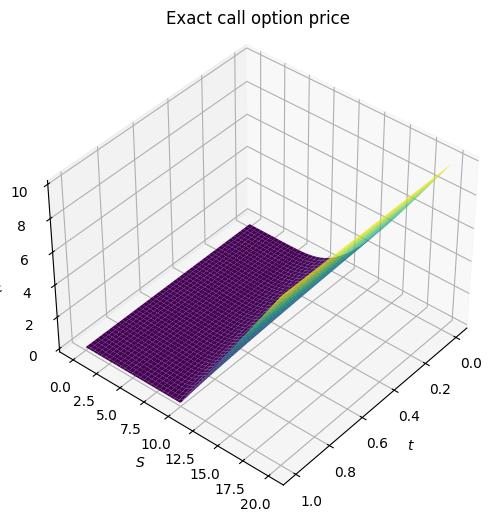

In [18]:
# 3D plot
V_star = griddata(X_star, v_star.flatten(), (t, s), method='cubic')
F_star = griddata(X_star, f_star.flatten(), (t, s), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (t, s), method='cubic')

# Surface plot of solution u(t,x)
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(t, s, V_star, cmap = "viridis")
ax.view_init(40,40)
ax.set_xlabel('$t$')
ax.set_ylabel('$S$')
ax.set_zlabel('$V(S,t)$')
ax.set_title('Exact call option price')

Text(0.5, 0.92, 'Predicted call option price')

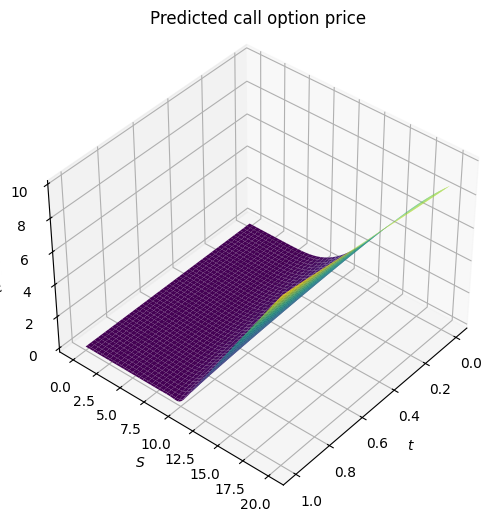

In [19]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(t, s, V_pred, cmap = "viridis")
ax.view_init(40,40)
ax.set_xlabel('$t$')
ax.set_ylabel('$S$')
ax.set_zlabel('$V(S,t)$')
ax.set_title('Predicted call option price')

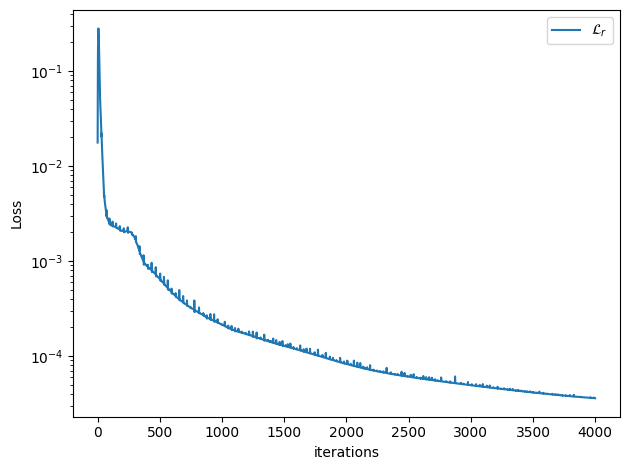

In [26]:
# Loss
loss_r = model.loss_r_log

fig_2 = plt.figure(2)
ax = fig_2.add_subplot(1, 1, 1)
ax.plot(loss_r, label='$\mathcal{L}_{r}$')
ax.plot()
ax.set_yscale('log')
ax.set_xlabel('iterations')
ax.set_ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Exact V(S,t)')

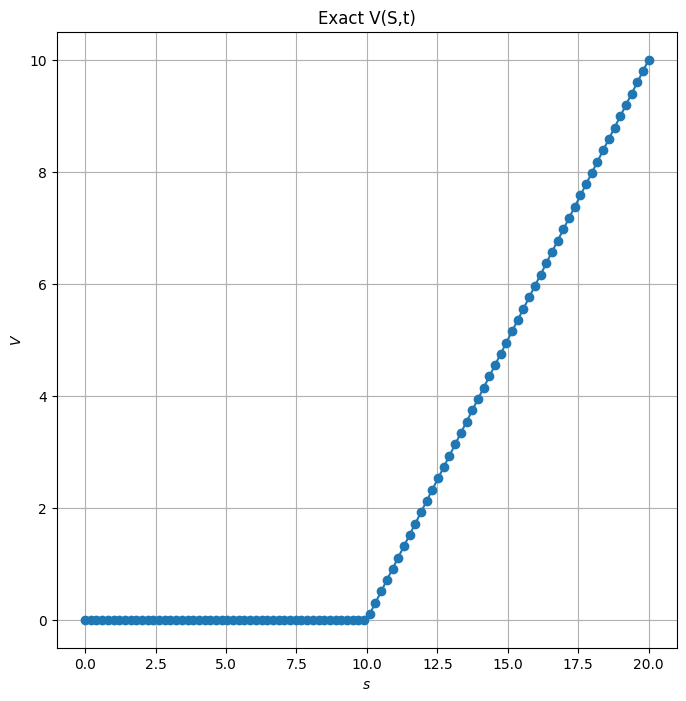

In [23]:
V_star = griddata(X_star, v_star.flatten(), (t, s), method='cubic')
F_star = griddata(X_star, f_star.flatten(), (t, s), method='cubic')

fig_1 = plt.figure(1, figsize=(8, 8))
plt.plot(s[:,-1],V_star[:,-1],marker = 'o')
plt.xlabel('$s$')
plt.ylabel('$V$')
plt.grid()
plt.title('Exact V(S,t)')